# Hydrology Data

In [1]:
from __future__ import annotations

import math
from pathlib import Path
from urllib.parse import urlencode

import geopandas as gpd
import rioxarray as rxr
import rioxarray.merge as rio_merge

import tiny_retriever as terry

In [2]:
duck = gpd.read_file("https://reference.geoconnex.us/collections/hu08/items/06040003")

Skipping field hucs: unsupported OGR type: 5


In [3]:
save_dir = Path("data")
save_dir.mkdir(exist_ok=True)
res = 10
base_url = (
    "https://elevation.nationalmap.gov/arcgis/rest/services/3DEPElevation/ImageServer/exportImage"
)
pixel_max = 8_000_000

xmin, ymin, xmax, ymax = duck.to_crs(5070).total_bounds
width = math.ceil((xmax - xmin) / res)
height = math.ceil((ymax - ymin) / res)
aspect_ratio = width / height
n_boxes = math.ceil((width * height) / pixel_max)
nx = math.ceil(math.sqrt(n_boxes * aspect_ratio))
ny = math.ceil(n_boxes / nx)

west, south, east, north = (round(x, 6) for x in duck.to_crs(4326).total_bounds)
dx = (east - west) / nx
dy = (north - south) / ny
sub_width = math.ceil(width / nx)
sub_height = math.ceil(height / ny)

url_list = []
tiff_list = []
for i in range(nx):
    box_west = west + (i * dx)
    box_east = min(west + ((i + 1) * dx), east)
    for j in range(ny):
        box_south = south + (j * dy)
        box_north = min(south + ((j + 1) * dy), north)
        params = {
            "bbox": f"{box_west},{box_south},{box_east},{box_north}",
            "bboxSR": 4326,
            "imageSR": 3857,
            "size": f"{sub_width},{sub_height}",
            "format": "tiff",
            "interpolation": "RSP_BilinearInterpolation",
            "f": "image",
        }
        url_list.append(f"{base_url}?{urlencode(params)}")
        dem_tif = terry.unique_filename(
            base_url, params=params, prefix="dem_", file_extension="tif"
        )
        dem_tif = save_dir / dem_tif
        tiff_list.append(dem_tif)
print(f"Number of tiles: {len(url_list)}")

Number of tiles: 12


In [4]:
terry.download(url_list, tiff_list, raise_status=False)
failed = [f for f in tiff_list if not f.exists()]
if failed:
    print(f"Failed to download {len(failed)} tiles.")
else:
    print("All tiles downloaded successfully.")

All tiles downloaded successfully.


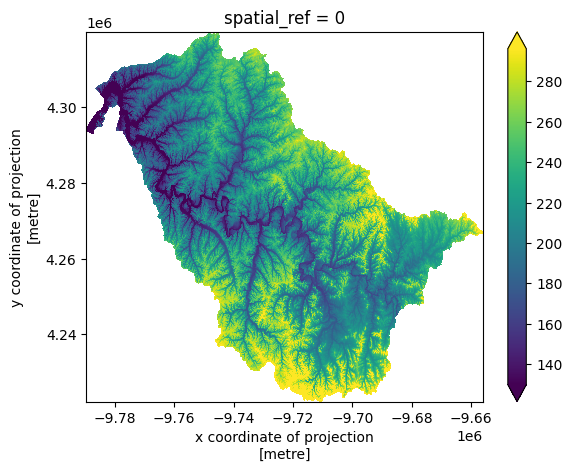

In [5]:
dem = rio_merge.merge_arrays([rxr.open_rasterio(f) for f in tiff_list]).squeeze(drop=True)
dem = dem.rio.clip_box(*duck.total_bounds, crs=duck.crs).rio.clip([duck.union_all()], crs=duck.crs)
_ = dem.plot.imshow(robust=True)